# 波動方程式

In [1]:
import numpy as np
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

波動方程式は、波動と定在波場を記述する2階線形偏微分方程式の一例である。1次元では、次のように記述される。
$$
\frac{\partial^2 \phi}{\partial t^2} = v^2 \frac{\partial^2 \phi}{\partial x^2}.
$$

これは2階偏微分方程式であるため、$\phi(t=0,x)$ と $\phi_t'(t=0,x)$ の両方の初期条件が補足される。
\begin{align*}
\phi(t=0,x) & = \phi_0(x) ,\\
\phi_t'(t=0,x) & = \phi'_0(x).
\end{align*}

境界条件は、ディリクレ形式
\begin{align*}
\phi(t,x=0) & = \phi_{\rm left}(t) ,\\
\phi(t,x=L) & = \phi_{\rm right}(t),
\end{align*}
またはノイマン形式
\begin{align*}
\phi'_x(t,x=0) & = \phi'_{\rm left}(t) ,\\
\phi'_x(t,x=L) & = \phi'_{\rm right}(t),
\end{align*}
のいずれかとなる。

ここではディリクレ形式を考える。

## 有限差分アプローチ

2階の時間微分を扱うために、次のように表記する。
$$
\psi(t,x) \equiv \frac{\partial \phi}{\partial t}
$$
このようにして、1階（$t$ 方向）偏微分方程式系を扱う。
\begin{align*}
\frac{\partial \phi}{\partial t} = \psi(t,x), \\
\frac{\partial \psi}{\partial t} = v^2 \frac{\partial^2 \phi}{\partial x^2}.
\end{align*}

差分法を適用するには、まず、熱方程式の場合と同様に、導関数 $\partial^2 \phi / \partial x^2$ を最低階の中心差分で近似する。
$$
\frac{\partial^2 \phi(t,x)}{\partial x^2} \approx \frac{\phi(t,x+a) - 2\phi(t,x) + \phi(t,x-a)}{a^2}.
$$

偏微分方程式を数値的に解くには、熱方程式の場合と同じ手順を、$\phi(t,x)$ と $\psi(t,x)$ を同時に適用する。
$\phi(t = nh,x = ka) = \phi^n_k$ および $\psi(t = nh,x = ka) = \psi^n_k$ と書くと、次の式が得られる。

### FTCS 法
$$
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^n_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^n_{k+1} - 2\phi^n_k + \phi^n_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}
$$
### 陰解法
$$
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^{n+1}_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}
$$

### Crank-Nicolson 法
$$
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + \frac{h}{2} \left[ \psi^{n+1}_k + \psi^{n}_k\right], \\
\psi^{n+1}_k & = \psi^n_k + \frac{r}{2} \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}) + \frac{r}{2} \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}
$$

ここでは、Crank-Nicolson法で解くことを考えよう。

第1式を第2式に代入すると、$\psi^{n+1}_k$の三角対角な線形方程式系が得られる：
$$
-rh \psi^{n+1}_{k+1} + 2(1+rh) \psi^{n+1}_k - rh \psi^{n+1}_{k-1} = 2 \psi^n_k + 2r \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}) + rh \, (\psi^{n}_{k+1} - 2\psi^{n}_k + \psi^{n}_{k-1}), \quad k = 1\ldots N-1.
$$

これを、上での熱伝導方程式の場合を参考にして、解いてみよ。
プロットする際には例として t= 1., 5., 10., 20., 190., 290. で見積もってみよ。

In [2]:
from scipy.linalg import solve_banded

# 準備: 三重対角線線形方程式を解くコード
# d: 対角要素のベクトル
# l: 下側下対角要素のベクトル
# u: 上側上対角要素のベクトル
# v0: 右辺ベクトル
def linsolve_tridiagonal(d, l, u, v0):
    """
    x = (ab)^{-1} v0 を solve_banded を使って求める。
    solve_banded の引数3つ：
    - (l,u)=(1,1): 上下対角成分がそれぞれ1個ずつの意味
    - ab: n重対角行列。対角成分のベクトルを並べる。この場合は上下対角がそれぞれ1つずつなので、3重対角。
    - v0: 右辺のベクトル
    """
    
    ab = np.array([u, d, l])
    x = solve_banded((1,1), ab, v0)

    return x

In [3]:
import numpy as np

# Crank-Nicolson法での時間方向の1ループ
# h: 時間ステップ
# r = Dh/a^2: 無次元パラメタ
def wave_crank_nicolson_iteration(phi, psi, h, r):
    N = len(phi) - 1
    
    phinew = np.empty_like(phi)
    psinew = np.empty_like(psi)
    
    # 境界条件 (Dirichlet)
    phinew[0] = phi[0]
    phinew[N] = phi[N]
    psinew[0] = 0.
    psinew[N] = 0.
    
    # psi についての三重対角方程式
    d  = np.full(N-1, 2*(1+r*h))
    ud = np.full(N-1, -r*h)
    ld = np.full(N-1, -r*h)
    v  = np.array(2*psi[1:N] + 2*r*phi[2:] - 4*r*phi[1:N] + 2*r*phi[:-2] \
                  + r*h*psi[2:] - 2*r*h*psi[1:N] + r*h*psi[:-2])
    v[0]   += r * h * psi[0]
    v[N-2] += r * h * psi[N]
    
    psinew[1:N] = linsolve_tridiagonal(d,ld,ud,v)
    
    # phi の更新
    for i in range(1,N):
        phinew[i] = phi[i] + h * (psinew[i] + psi[i]) / 2
        
    return phinew, psinew


# Crank-Nicolsonをnsteps分反復して波動方程式を解く
# phi0, psi0: 初期条件
# h: 時間ステップの刻み幅
# nsteps: 時間ステップの数
# a: 空間方向の刻み幅
# v: 波動の伝播速度
def wave_crank_nicolson_solve(phi0, psi0, h, nsteps, a, v = 1.):
    phi = phi0.copy()
    psi = psi0.copy()
    r = h * v**2 / a**2
    for i in range(nsteps):
        phi, psi = wave_crank_nicolson_iteration(phi, psi, h, r)
        
    return phi, psi

Solving the wave equation with Crank-Nicolson scheme
r = h*v^2/a^2 = 1.0000000000000002
100
400
500
1000
17000
10000


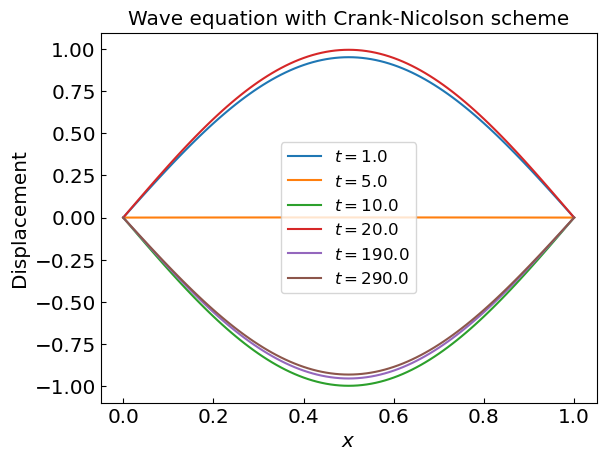

CPU times: user 3.27 s, sys: 139 ms, total: 3.41 s
Wall time: 3.26 s


In [4]:
%%time

# 定数
L = 1         # 弦の長さ
v = 0.1       # 波動の伝播速度
N = 100       # 弦の空間座標のグリッドの数
a = L/N       # 空間座標の刻み幅
h = 1e-2      # 時間の刻み幅

print("Solving the wave equation with Crank-Nicolson scheme")
print("r = h*v^2/a^2 =",h*v**2/a**2)



# 初期化
phi = np.array([np.sin(k*np.pi/N) for k in range(N+1)]) # phi を正弦関数で与える。
psi = np.zeros([N+1],float) # psi はゼロ。つまり、弦をそっと離すことに対応

# 出力のための配列
times    = [ 1., 5., 10., 20., 190., 290.] # 出力する時刻
profiles = [] # 振幅の配列
xk       = [k*a for k in range(0,N+1)] # 離散化された空間座標

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    print(nsteps)
    phi, psi = wave_crank_nicolson_solve(phi, psi, h, nsteps, a, v)
    profiles.append(phi.copy())
    current_time = time
    
plt.title("Wave equation with Crank-Nicolson scheme")
plt.xlabel('${x}$')
plt.ylabel('Displacement')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]))
plt.legend()
plt.show()

アニメーション

In [5]:
%%time

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 定数
L = 1         # 弦の長さ
v = 0.1       # 波動の伝播速度
N = 100       # 弦の空間座標のグリッドの数
a = L/N       # 空間座標の刻み幅
h = 1e-2      # 時間の刻み幅

# プロットのため
xk       = [k*a for k in range(0,N+1)]

# Initialize for the three schemes
phi = np.array([np.sin(k*np.pi/N) for k in range(N+1)])
psi = np.zeros([N+1],float)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
current_time = 0
def animate_wave_equation_1D(i):
    ax.clear()
    global fps, tottime, tend
    nsteps = round((tend/tottime/fps)/h)
    global phi, psi, current_time
    phi, psi = wave_crank_nicolson_solve(phi, psi, h, nsteps, a, v)
    current_time += h * nsteps
    
    plt.title("${t=}$" + "{:.3f}".format(current_time))
    plt.xlabel('${x}$')
    plt.ylabel('Displacement')
    plt.xlim(0,L)
    plt.ylim(-1.1,1.1)
    plt.plot(xk,phi,label="Crank-Nicolson")
    plt.legend(loc="upper right")

fps = 30
tend = 200.
tottime = 10.
ani = FuncAnimation(fig, animate_wave_equation_1D, frames=round(fps * tottime), interval=1000/fps, repeat=False)

# アニメーションを保存
ani.save("wave_equation_1D_CrankNicolson.gif")
plt.close()

# アニメーションを jupyter notebook 上でインタラクティブに表示
# HTML(ani.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


CPU times: user 34.9 s, sys: 1.92 s, total: 36.8 s
Wall time: 40.6 s


# 参考

### FTCS法

$$
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^n_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^n_{k+1} - 2\phi^n_k + \phi^n_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}
$$


In [6]:
def wave_FTCS_iteration(phi, psi, h, r):
    N = len(phi) - 1
    
    phinew = np.empty_like(phi)
    psinew = np.empty_like(psi)
    
    phinew[0] = phi[0]
    phinew[N] = phi[N]
    psinew[0] = 0.
    psinew[N] = 0.
    
    
    # FTCS 法
    for i in range(1,N):
        phinew[i] = phi[i] + h * psi[i]
        psinew[i] = psi[i] + r * (phi[i+1] - 2 * phi[i] + phi[i-1])
        
    return phinew, psinew

def wave_FTCS_solve(phi0, psi0, h, nsteps, a, v = 1.):
    phi = phi0.copy()
    psi = psi0.copy()
    r = h * v**2 / a**2
    for i in range(nsteps):
        phi, psi = wave_FTCS_iteration(phi, psi, h, r)
        
    return phi, psi

Solving the wave equation with FTCS scheme
r = h*v^2/a^2 = 1.0000000000000002


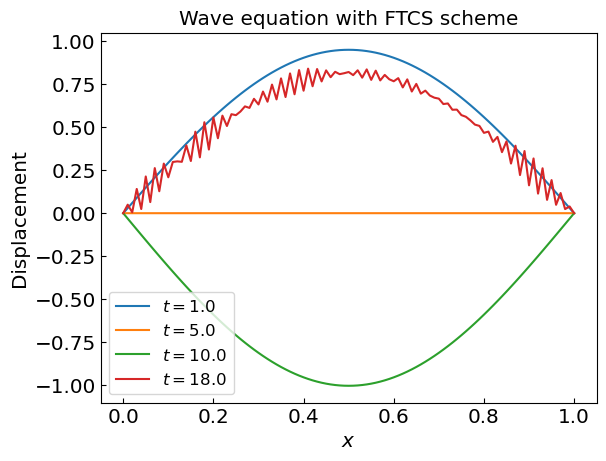

CPU times: user 515 ms, sys: 115 ms, total: 630 ms
Wall time: 451 ms


In [7]:
%%time

# 定数
L = 1         # 弦の長さ
v = 0.1       # 波動の伝播速度
N = 100       # 弦の空間座標のグリッドの数
a = L/N       # 空間座標の刻み幅
h = 1e-2      # 時間の刻み幅

print("Solving the wave equation with FTCS scheme")
print("r = h*v^2/a^2 =",h*v**2/a**2)

phi = np.array([np.sin(k*np.pi/N) for k in range(N+1)])
psi = np.zeros([N+1],float)

times    = [ 1., 5., 10., 18.]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    phi, psi = wave_FTCS_solve(phi, psi, h, nsteps, a, v)
    profiles.append(phi.copy())
    current_time = time
    
plt.title("Wave equation with FTCS scheme")
plt.xlabel('${x}$')
plt.ylabel('Displacement')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]))
plt.legend()
plt.show()

### 陰解法
$$
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^{n+1}_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}
$$

第2式を第1式に代入して、$\phi^{n+1}$を消去して、$\psi^{n+1}$の線型方程式に帰着:
$$
-rh \psi^{n+1}_{k+1} + (1+2rh) \psi^{n+1}_k - rh \psi^{n+1}_{k-1} = \psi^n_k + r \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}), \quad k = 1\ldots N-1
$$

In [8]:
def wave_implicit_iteration(phi, psi, h, r):
    N = len(phi) - 1
    
    phinew = np.empty_like(phi)
    psinew = np.empty_like(psi)
    
    phinew[0] = phi[0]
    phinew[N] = phi[N]
    psinew[0] = 0.
    psinew[N] = 0.
    
    d  = np.full(N-1, 1+2.*r*h)
    ud = np.full(N-1, -r*h)
    ld = np.full(N-1, -r*h)
    v  = np.array(psi[1:N] + r*phi[2:] - 2*r*phi[1:N] + r*phi[:-2])
    v[0]   += r * h * psi[0]
    v[N-2] += r * h * psi[N]
    
    psinew[1:N] = linsolve_tridiagonal(d,ld,ud,v)
    
    for i in range(1,N):
        phinew[i] = phi[i] + h * psinew[i]
        
    return phinew, psinew


def wave_implicit_solve(phi0, psi0, h, nsteps, a, v = 1.):
    phi = phi0.copy()
    psi = psi0.copy()
    r = h * v**2 / a**2
    for i in range(nsteps):
        phi, psi = wave_implicit_iteration(phi, psi, h, r)
        
    return phi, psi

Solving the wave equation with implicit scheme
r = h*v^2/a^2 = 1.0000000000000002


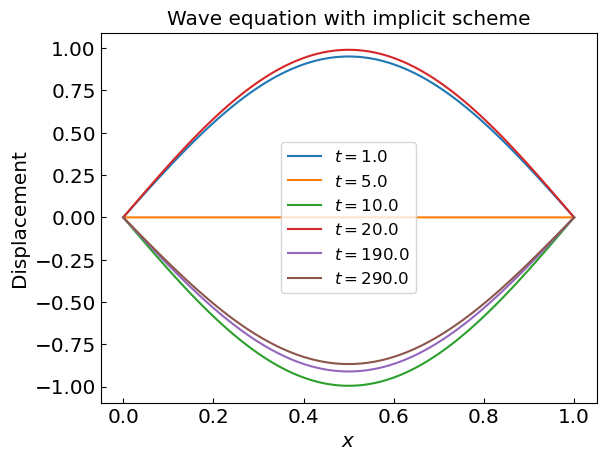

CPU times: user 3.14 s, sys: 108 ms, total: 3.25 s
Wall time: 3.77 s


In [9]:
%%time

# 定数
L = 1         # 弦の長さ
v = 0.1       # 波動の伝播速度
N = 100       # 弦の空間座標のグリッドの数
a = L/N       # 空間座標の刻み幅
h = 1e-2      # 時間の刻み幅

print("Solving the wave equation with implicit scheme")
print("r = h*v^2/a^2 =",h*v**2/a**2)

phi = np.array([np.sin(k*np.pi/N) for k in range(N+1)])
psi = np.zeros([N+1],float)

times    = [ 1., 5., 10., 20., 190., 290.]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    phi, psi = wave_implicit_solve(phi, psi, h, nsteps, a, v)
    profiles.append(phi.copy())
    current_time = time
    
plt.title("Wave equation with implicit scheme")
plt.xlabel('${x}$')
plt.ylabel('Displacement')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]))
plt.legend()
plt.show()

# 初期条件を変えた場合

In [10]:
%%time

# 定数
L = 1         # 弦の長さ
d = 0.1       # パルスの初期条件
sig = 0.3     # パルスの初期条件
v = 100.      # 波動の伝播速度
N = 100       # 弦の空間座標のグリッドの数
a = L/N       # 空間座標の刻み幅
h = 1e-6      # 時間の刻み幅


phi1 = np.zeros([N+1],float)
psi1 = np.array([a*k * (L - a*k) / L**2 * np.exp(-(k*a-d)**2/2/sig**2) for k in range(N+1)])
phi2 = phi1.copy()
psi2 = psi1.copy()
phi3 = phi1.copy()
psi3 = psi1.copy()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Wave equation", fontsize = 18)
current_time = 0
def animate_wave_equation_1D_pulse(i):
    ax.clear()
    global fps, tottime, tend
    nsteps = round((tend/tottime/fps)/h)
    global phi1, psi1, phi2, psi2, phi3, psi3, current_time
    phi1, psi1 = wave_FTCS_solve(phi1, psi1, h, nsteps, a, v)
    phi2, psi2 = wave_implicit_solve(phi2, psi2, h, nsteps, a, v)
    phi3, psi3 = wave_crank_nicolson_solve(phi3, psi3, h, nsteps, a, v)
    current_time += h * nsteps
    
    plt.title("${t=}$" + "{:.3f}".format(current_time))
    plt.xlabel('${x}$')
    plt.ylabel('Displacement')
    plt.xlim(0,L)
    plt.ylim(-0.0005,0.0005)
    # plt.plot(xk,phi1,label="FTCS")
    plt.plot(xk,phi2,label="Implicit")
    plt.plot(xk,phi3,label="Crank-Nicolson")
    plt.legend(loc="upper right")
    # plt.show()

fps = 30
tend = 0.2
tottime = 10.
ani = FuncAnimation(fig, animate_wave_equation_1D_pulse, frames=round(fps * tottime), interval=1000/fps, repeat=False)

ani.save("wave_equation_1D_pulse.gif")
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


CPU times: user 1min 22s, sys: 2.65 s, total: 1min 25s
Wall time: 1min 31s
